In [40]:
import numpy as np
import preprocessing as pp
import matplotlib.pyplot as plt
from graph import *

import models
from models.multivariate_gaussian_classifier import *

In [41]:
X, y = utils.load_data()

classes = {
    'Fake': 'blue',
    'Real': 'orange'
}

### Apply the MVG model to the project data.

In [42]:
X_train, y_train, X_test, y_test = utils.split_data(X, y)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

pi = 0.5

X_train shape: (6, 4000)
X_test shape: (6, 2000)


In [43]:
models_dict = {
    'MVG': MultivariateGaussianClassifier(),
    'NB': NaiveBayesClassifier(),
    'TC': TiedCovarianceClassifier(),
}

In [44]:
threshold = -np.log(pi / (1 - pi))

for model_name, model in models_dict.items():
    model.fit(X_train, y_train)
    
    accuracy = model.predict_binary(X_test, y_test, threshold)
    
    print(f'{model_name} Accuracy: {accuracy*100:.2f}% (threshold: {threshold:.2f})')

MVG Accuracy: 93.00% (threshold: -0.00)
NB Accuracy: 92.80% (threshold: -0.00)
TC Accuracy: 90.70% (threshold: -0.00)


### Model accuracy comparison:
- LDA model accuracy: LDA Accuracy: `90.70%` (threshold: `-0.02`)
- MVG model accuracy: MVG Accuracy: `93.00%` (threshold: `0.00`)
- TC model accuracy: TC Accuracy: `90.70%` (threshold: `0.00`)
- NB model accuracy: NB Accuracy: `92.80%` (threshold: `0.00`)

### Correlation analysis
#### On the project data:

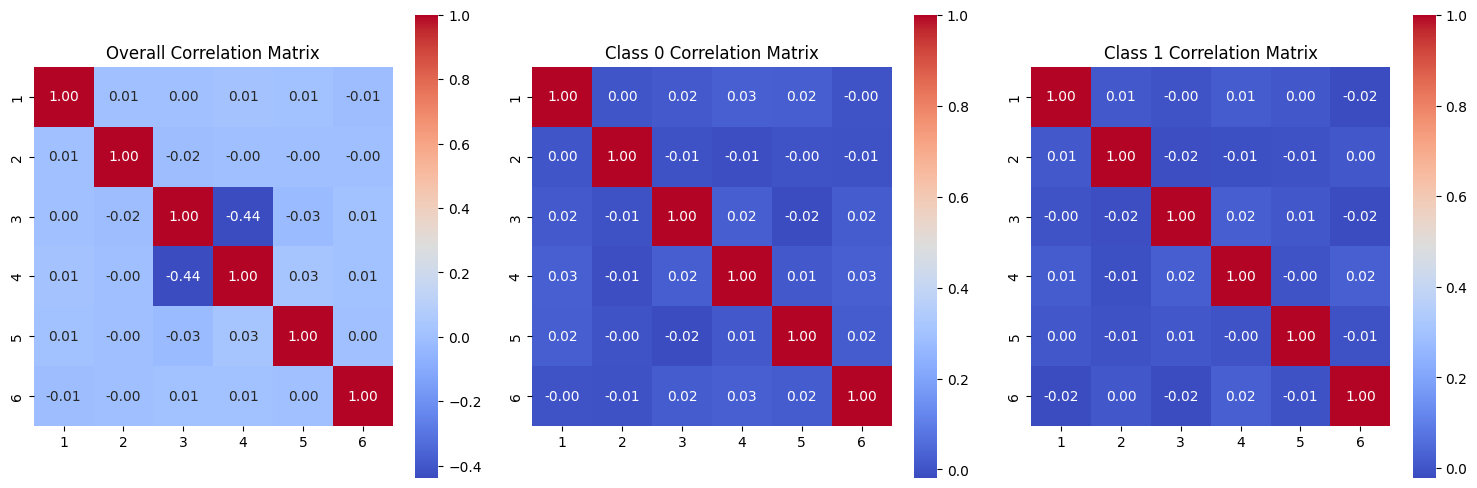

In [45]:
plot_correlation_matrix(X, y)

#### Feature 1 to 4:
Analyze if the last set of features negatively affects the model's performance because of poor modeling assumptions.

In [46]:
def log_gau_pdf(X, mu, sigma):
    """ Compute the log of the Gaussian pdf
        X: n_features, n_samples
        mu: class mean
        sigma: class covariance matrix
    """
    
    if X.shape[0] < X.shape[1]:
        X = X.T
    
    _, d = X.shape # n: samples, d: features,
    X_c = X - mu.reshape(1, -1)
    inv_sigma = np.linalg.inv(sigma)
    sign, log_det_sigma = np.linalg.slogdet(sigma)
    det_sign = sign * log_det_sigma
    quad_form = np.sum(X_c @ inv_sigma * X_c, axis=1)
    log_pdf = -0.5 * (d * np.log(2 * np.pi) + det_sign + quad_form)
    
    return log_pdf

X_f14 shape: (4, 6000)


<Figure size 640x480 with 0 Axes>

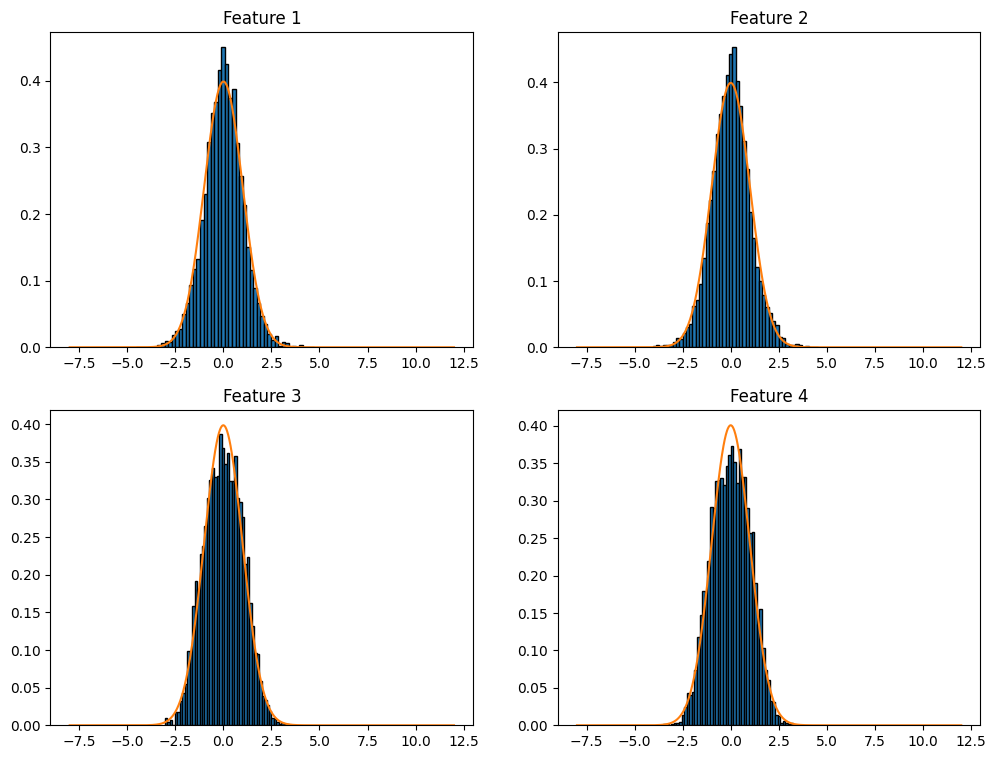

In [47]:
X_f14 = X[:-2, :]
print(f'X_f14 shape: {X_f14.shape}')

Xplot = np.linspace(-8, 12, 1000).reshape(-1, 1)

plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(12, 9))


for i in range(4):
    X_1 = X_f14[i:i+1, :].T
    mean = np.mean(X_1, axis=0).reshape(-1, 1)
    cov = np.dot((X_1 - mean).T, (X_1 - mean)) / X_1.shape[0]
    
    ax = axs[i//2, i%2]
    ax.hist(X_f14[i], bins=50, density=True, ec='black')
    ax.plot(Xplot.ravel(), np.exp(log_gau_pdf(Xplot, mean, cov)))
    ax.set_title(f'Feature {i+1}')

In [48]:
X_train_f14, y_train_f14, X_test_f14, y_test_f14 = utils.split_data(X_f14, y)

for model_name, model in models_dict.items():
    model.fit(X_train_f14, y_train_f14)
    
    accuracy = model.predict_binary(X_test_f14, y_test_f14, threshold)
    
    print(f'{model_name} Accuracy: {accuracy*100:.2f}% (threshold: {threshold:.2f})')

MVG Accuracy: 92.05% (threshold: -0.00)
NB Accuracy: 92.35% (threshold: -0.00)
TC Accuracy: 90.50% (threshold: -0.00)


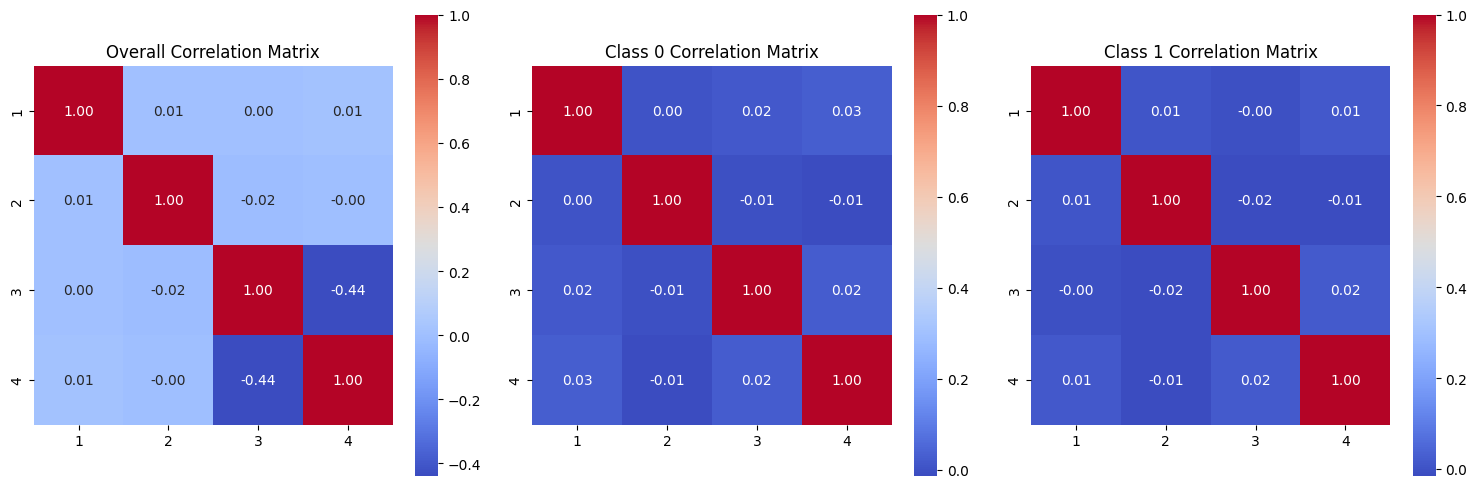

In [49]:
plot_correlation_matrix(X_f14, y)

#### Apply PCA to the new feature set and compute the accuracy of the models.

In [50]:
def compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models, threshold):
    results = {model_name: [] for model_name in models.keys()}
    
    for i in reversed(range(X_train.shape[0])):
        X_train_pca, eig_v = pp.pca(data=X_train, n_features=i+1, required_eigen_vectors=True)
        X_test_pca = np.dot(eig_v.T, X_test)
        
        for model_name, model in models.items():
            model.fit(X_train_pca, y_train)
            accuracy = model.predict_binary(X_test_pca, y_test, threshold)
            results[model_name].append((i+1, accuracy))
    
    plt.figure(figsize=(10, 6))
    
    for model_name, acc in results.items():
        features, accuracies = zip(*acc)
        plt.plot(features, accuracies, marker='o', label=model_name)
        
    plt.xlabel('Number of PCA features')
    plt.ylabel('Accuracy')
    plt.title('Model accuracy with Varying PCA Features')
    plt.legend()
    plt.grid(True)
    plt.gca()
    plt.show()
    
    return results

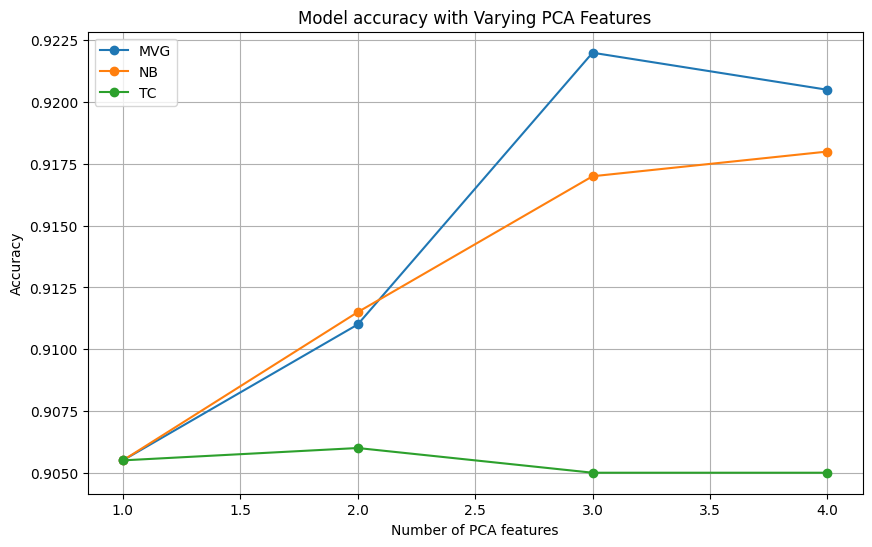

MVG - Best Accuracy: (3, 0.922)
NB - Best Accuracy: (4, 0.918)
TC - Best Accuracy: (2, 0.906)


In [51]:
res = compute_accuracy_model_pca(X_train_f14, y_train, X_test_f14, y_test, models_dict, threshold)
for model_name, acc in res.items():
    print(f'{model_name} - Best Accuracy: {max(acc, key=lambda x: x[1])}')

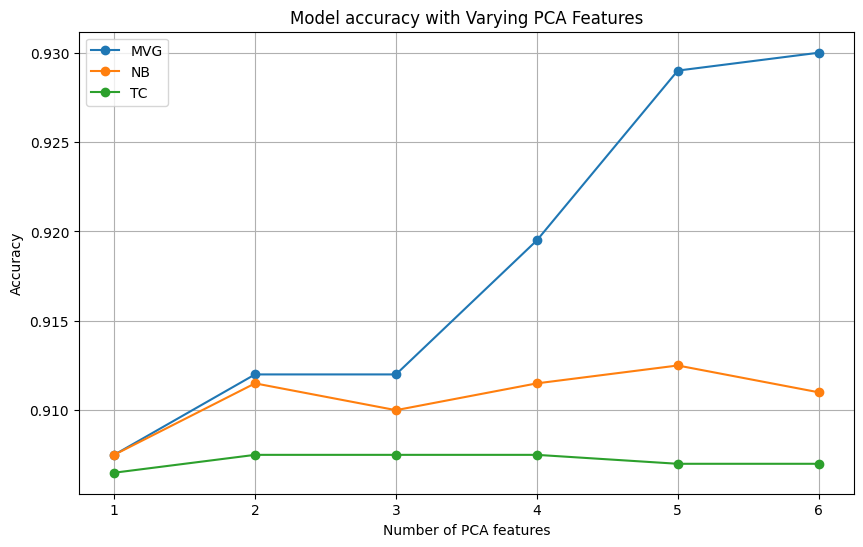

MVG - Best Accuracy: (6, 0.93)
NB - Best Accuracy: (5, 0.9125)
TC - Best Accuracy: (4, 0.9075)


In [52]:
X_train, y_train, X_test, y_test = utils.split_data(X, y)
res = compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models_dict, threshold)
for model_name, acc in res.items():
    print(f'{model_name} - Best Accuracy: {max(acc, key=lambda x: x[1])}')